In [7]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


In [8]:

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('./modified_dataset2.csv')

# Feature Engineering
df['LinguisticScore'] = (df['ReadingScore'] + df['WritingScore']) / 2



## Data Scaling

In [9]:
# Normalize the data
scaler = StandardScaler()
feature_columns = [
            'NrSiblings', 'ReadingScore', 'WritingScore',
            'Gender_male', 'EthnicGroup_group A', 'EthnicGroup_group B',
            'EthnicGroup_group C', 'EthnicGroup_group D', 'EthnicGroup_group E',
            'LunchType_standard', 'TestPrep_completed', 'TestPrep_none',
            'ParentMaritalStatus_divorced', 'ParentMaritalStatus_married',
            'ParentMaritalStatus_single', 'ParentMaritalStatus_widowed',
            'TransportMeans_private', 'TransportMeans_school_bus', 'LinguisticScore'
        ]
scaled_df = scaler.fit_transform(df[feature_columns])


## Find the right number of clusters

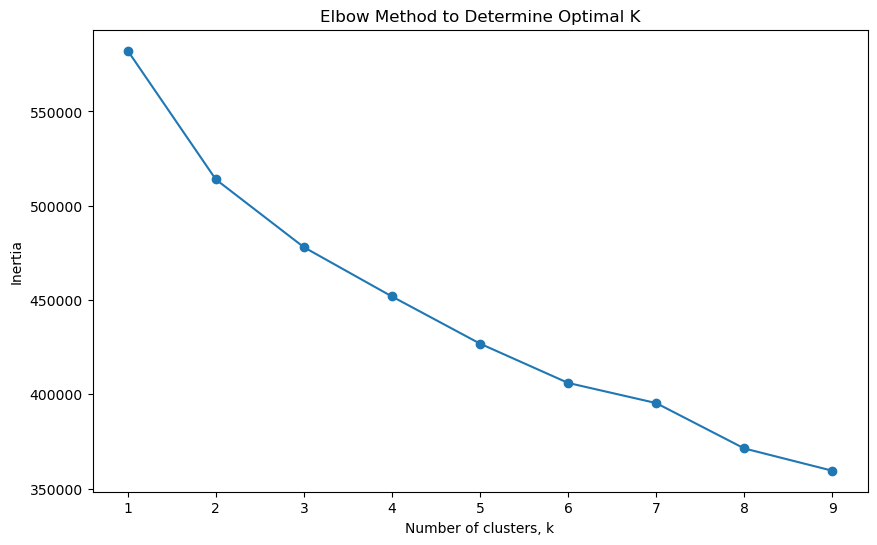

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate the sum of squared distances (inertia) for a range of k values
inertia = []
k_values = range(1, 10)  

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)

    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

# Plot the inertia to see where the "elbow" is
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, '-o')
plt.title('Elbow Method to Determine Optimal K')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()


The elbow chart suggests that the inertia (or within-cluster sum of squares) decreases as the number of clusters increases, which is expected. However, there is no clear "elbow," or point at which the rate of decrease sharply changes, indicating a natural number of clusters.

When there is no obvious elbow, it could mean several things:

**The Data is Uniformly Distributed:** There may not be distinct clusters in the data, and the data points might be evenly distributed across the feature space.


**Complex Cluster Shapes:** K-Means assumes that clusters are spherical and evenly sized, which may not be the case in your data. If clusters have irregular shapes or densities, K-Means might not be the best algorithm to use.


**High-Dimensional Data:** If the data has many dimensions, it can be difficult for K-Means to find distinct clusters, and PCA might not capture the necessary information if it reduces dimensions too much.

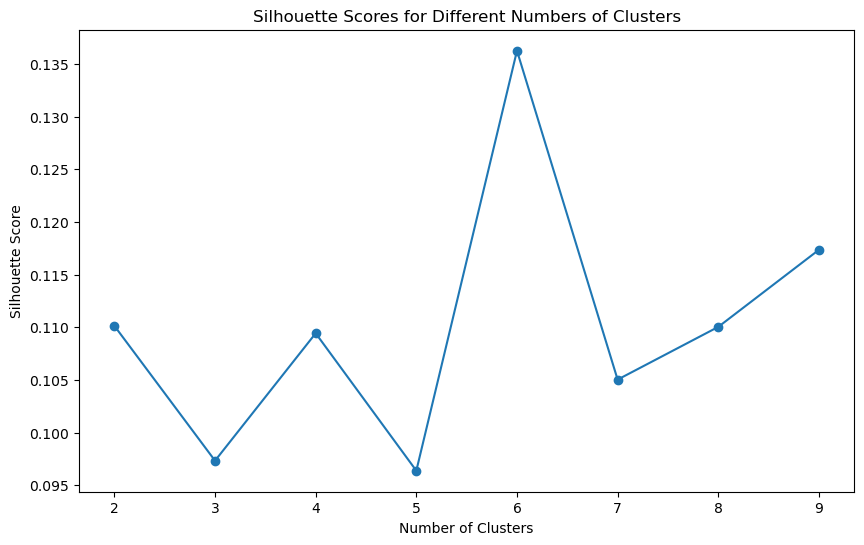

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Calculate silhouette scores for a range of k values
silhouette_scores = []
k_values = range(2, 10)  
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaled_df)
    labels = kmeans.labels_
    score = silhouette_score(scaled_df, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, 'o-')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.show()


Given the highest silhouette score is not very high, we are going to consider if K-Means is the right algorithm for the data.    


The silhouette scores for different numbers of clusters are relatively low, with the highest peak around 0.135 for 5 clusters. Generally, a silhouette score above 0.5 is considered good, and a score closer to 1 is considered very good. Scores below 0.25 might indicate that the clusters are overlapping significantly. Also we are going to try out if DBSCAN yields better results.  

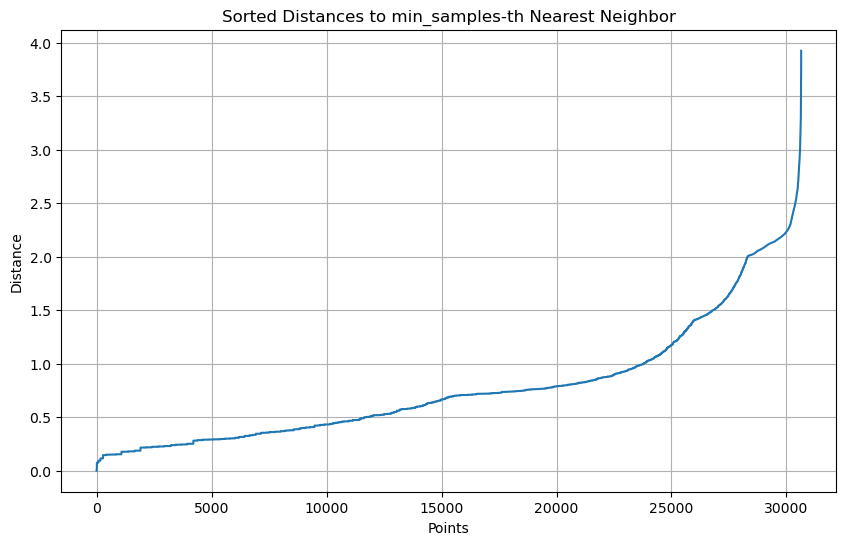

In [12]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


# Use NearestNeighbors to find the distance to the min_samples-th nearest neighbor for each point
min_samples = 5
nearest_neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = nearest_neighbors.fit(scaled_df)
distances, indices = neighbors_fit.kneighbors(scaled_df)

# Sort the distances
sorted_distances = np.sort(distances[:, min_samples-1])

# Plot the sorted distances
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.title('Sorted Distances to min_samples-th Nearest Neighbor')
plt.xlabel('Points')
plt.ylabel('Distance')
plt.grid(True)
plt.show()


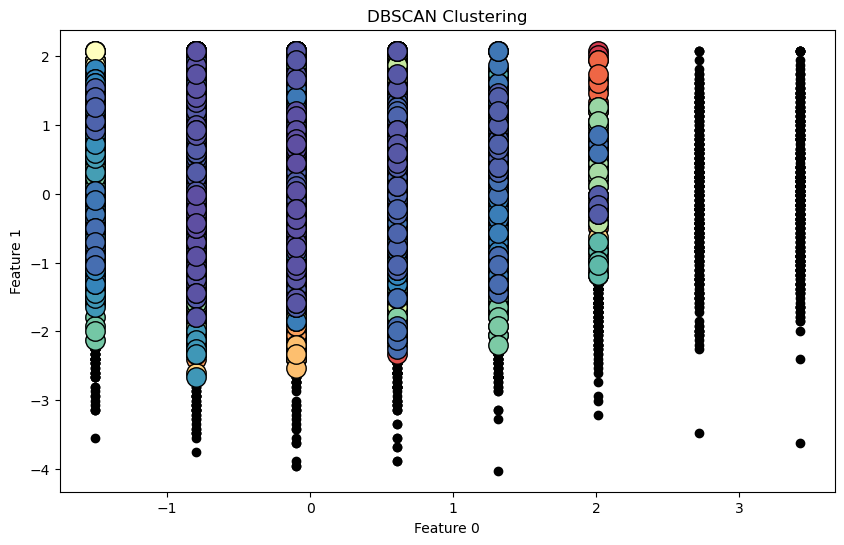

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np



eps_value = 0.5  
min_samples = 5  

# Run DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(scaled_df)

# Plotting the results
x_column_index = 0
y_column_index = 1

plt.figure(figsize=(10, 6))

# Scatter plot of the data points, colored by DBSCAN labels
unique_labels = np.unique(dbscan_labels)
for label in unique_labels:
    # Color the noise (label == -1) in black
    if label == -1:
        color = 'k'
    else:
        color = plt.cm.Spectral(float(label) / len(unique_labels))
    
    class_member_mask = (dbscan_labels == label)
    xy = scaled_df[class_member_mask]
    plt.plot(xy[:, x_column_index], xy[:, y_column_index], 'o', markerfacecolor=color, markeredgecolor='k', markersize=6 if label == -1 else 14)

plt.title('DBSCAN Clustering')
plt.xlabel(f'Feature {x_column_index}')
plt.ylabel(f'Feature {y_column_index}')
plt.show()


Chi-Square Statistic: 319412.97718742845
P-value: 0.0


/var/folders/lh/pnv5lwxd567bn94zd1hndztc0000gn/T/ipykernel_13739/438691653.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(feature_data, shade=True, color="r")


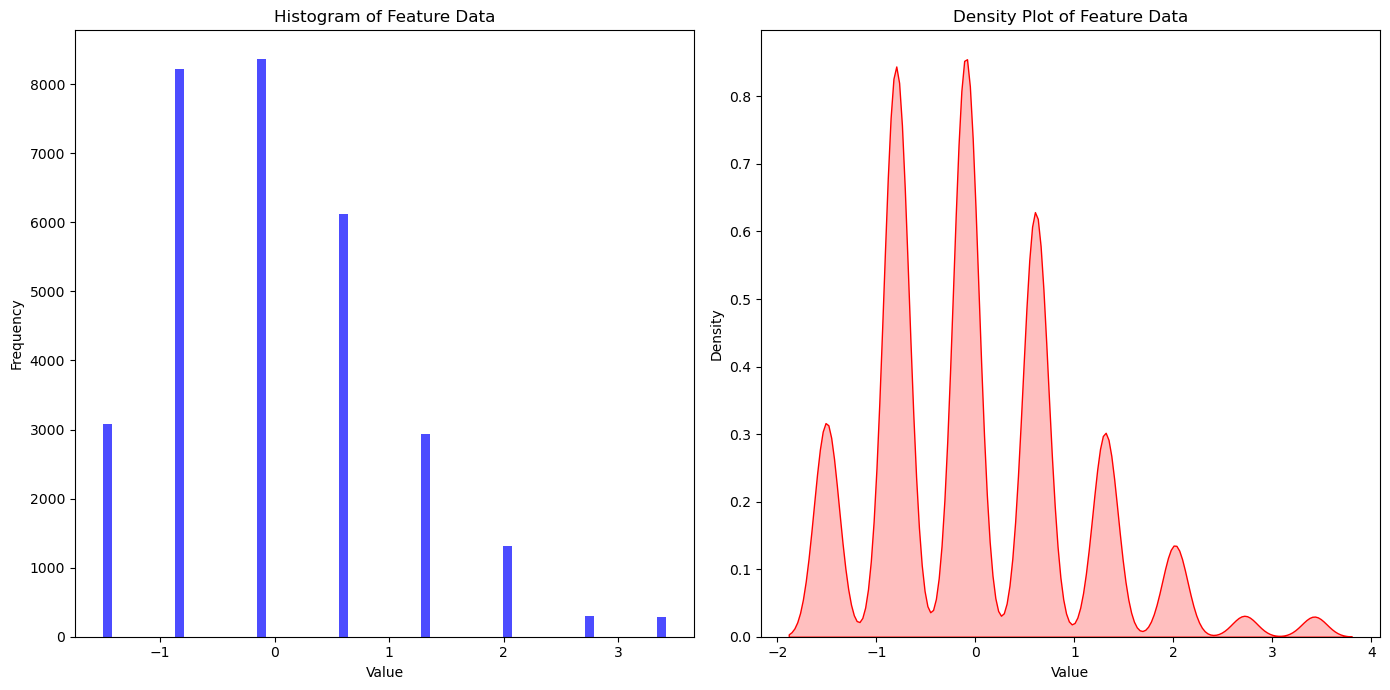

In [14]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# For demonstration, we'll use one feature from the dataset.
feature_data = scaled_df[:, 0]

# Chi-Square Goodness of Fit Test
# We expect the data to follow a uniform distribution if there's no clustering structure.
# We'll first create observed frequencies by binning the data
observed_frequencies, bins = np.histogram(feature_data, bins='auto')
# The expected frequencies if the data was uniformly distributed
expected_frequencies = np.ones_like(observed_frequencies) * np.mean(observed_frequencies)

# Perform the Chi-Square test
chi_square_stat, p_value = stats.chisquare(observed_frequencies, expected_frequencies)

print("Chi-Square Statistic:", chi_square_stat)
print("P-value:", p_value)

# Visual Inspection with Histogram and Density Plot
plt.figure(figsize=(14, 7))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(feature_data, bins='auto', color='blue', alpha=0.7, rwidth=0.85)
plt.title('Histogram of Feature Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(feature_data, shade=True, color="r")
plt.title('Density Plot of Feature Data')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()



## Use Clustering Labels with Original Features

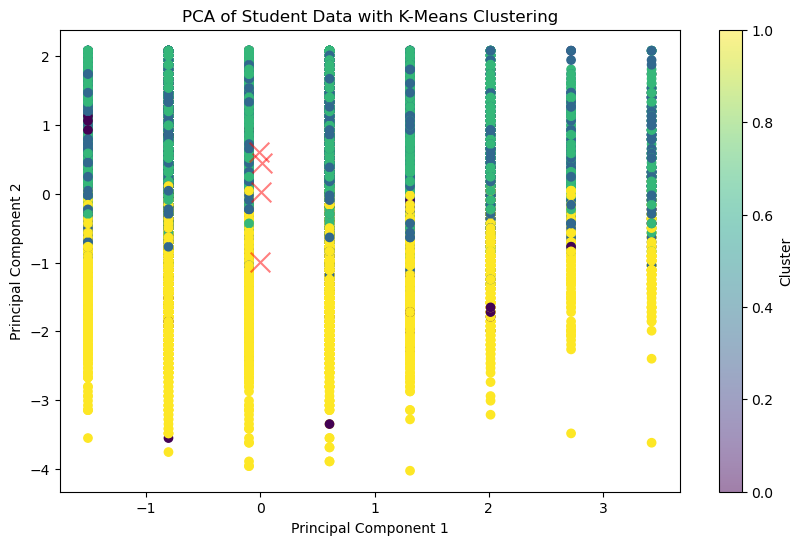

In [15]:
import matplotlib.pyplot as plt

# Perform K-Means clustering (assuming this is done as shown previously)
kmeans = KMeans(n_clusters=4, n_init=10)
clusters = kmeans.fit_predict(scaled_df)
# Get cluster centers
cluster_centers = kmeans.cluster_centers_

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(scaled_df[:, 0], scaled_df[:, 1], c=clusters, cmap='viridis', marker='o')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, alpha=0.5, marker='x')  # Annotate cluster centers

plt.title('PCA of Student Data with K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Adding a color bar to show the cluster colors
plt.colorbar(label='Cluster')

# Show the plot
plt.show()


## Cluster Profiles:


##  Interpreting PCA Components:

**High Absolute Values:** The features with high absolute values in PC1 or PC2 are the ones that have a strong influence on that principal component. For example, WritingScore, ReadingScore, and LinguisticScore have high loadings for PC1, which means they contribute significantly to the variance explained by the first principal component.


**Sign of Loadings:** The sign of the loadings indicates whether there is a positive or negative correlation with the principal component. For example, a positive loading means that as the feature value increases, the principal component value also tends to increase.



**Comparing Components:** By comparing the loadings across PC1 and PC2, you can see which features have more influence on which component. For instance, TransportMeans_private and TransportMeans_school_bus have almost no influence on PC1, but they have a very high influence on PC2, suggesting that they primarily contribute to the variance captured by the second principal component.

## Feature Importance (PCA Loadings):


## PCA Analysis and Feature Importance

- The PCA analysis seems to suggest that **academic scores** (specifically reading and writing) and **test preparation status** are important factors that differentiate students in the dataset when looking at **PC1**.

- The **mode of transportation** significantly differentiates students along **PC2**, which may reflect non-academic factors. The strong opposition in loadings between `TransportMeans_private` and `TransportMeans_school_bus` also suggests a potential **socioeconomic dimension**, as students typically do not use both private transportation and school buses simultaneously.

- The **clustering of students**, considering these principal components, would likely reflect these influences, with clusters potentially representing groups of students with varying academic performances and socioeconomic backgrounds.
